#2η ομαδική εργασία στη Τεχνολογία και Ανάλυση Εικόνων και Βίντεο

# **Θεωρητικό Μέρος**

**Παρουσιάστε ένα συγκριτικό πίνακα με τα επίπεδα, το μέγεθος των φίλτρων, τη συνάρτηση ενεργοποίησης, το πλήθος παραμέτρων και τεχνικές pooling και dropout που χρησιμοποιούν τα 3 διαφορετικά δίκτυα που παρουσιάζονται στα προαναφερθέντα άρθρα και σχολιάστε ως προς την απόδοση τους. (Απαντήστε την ερώτηση μέσα σε κελί κειμένου στο Notebook που θα παραδώσετε).**


| Row/Header | Layers | Filter size | Activation func. | Parameters | Pooling | Dropout |
|------------|-------|-------|-------|-------|-------|-------|
| LeNet      | 7 | 5x5x6 | sigmoid | 2578 | average pooling, 2x2, stride 2 | - |
| AlexNet      | 11 | 11x11x96, 5x5x256, 3x3x384 | ReLU | 60 mil | max pooling, 3x3, stride 2| yes, p=0.5|
| VGG    | 16-19| 3x3x3 | ReLU| 138-144 mil| max pooling, 2x2, stride 2| yes, p=0.5|


---


Όπως είναι αναμενόμενο, το παλαιότερο μοντέλο LeNet είναι και το λιγότερο αποτελεσματικό 3.4% στο MNIST dataset ~ 12700 δείγματα. Έχει μικρότερο πλήθος επιπέδων, καθώς την εποχή δημιουργίας του δεν υπήρχαν τα υπολογιστικά μέσα για την εκπαίδευση μεγαλύτερου μοντέλου, ενώ συγχρόνως χρησιμοποιεί λιγότερο αποτελεσματική συνάρτηση ενεργοποίησης. Συγρόνως όμως είναι το πιο γρήγορο στην εκπαίδευση. Τα πιο εξελιγμένα μοντέλα, δίνουν μικρότερα σφάλματα (αναλογικά με το μέγεθος του dataset και το πλήθος των κλάσεων): AlexNet 37.5% στο ILSVRC-2010 με 1.4 mil δείγματα, VGG 25.5 - 28.1% στο ILSVRC-2012 με 1.45 mil. Χρησιμοποιούν πιο αποτελεσματικές τεχνικές και μειώνουν το overfitting με dropout στα τελικά πλήρως συνδεδεμένα επίπεδα. Έχουν, ωστόσο, μεγάλο πλήθος παραμέτρων προς εκπαίδευση.
Παρατηρώ πως η ακρίβεια βελτιώνεται όσο μεγαλώνει το βάθος του μοντέλου, αλλά αυτό συνεπάγεται και πιο χρονοβόρα εκπαίδευση.




---



#**Υλοποίηση Αλγορίθμου**

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [42]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)


In [44]:
# load the entire dataset
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [45]:
print(x_train_all.shape)

(50000, 32, 32, 3)


Η κάθε ομάδα θα δουλέψει με διαφορετικό υποσύνολο του dataset.
Στο επόμενο κελί, αντικαταστήστε την τιμή της μεταβλητής `team_seed` με τον αριθμό που αντιστοιχεί στην ομάδας σας.

In [46]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 59

In [47]:
# select from CIFAR100 20 classes
cifar100_classes_url = "https://pastebin.com/raw/nzE1n98V"

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [48]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [49]:
# print our classes
print(our_classes)

['apple', ' aquarium_fish', ' bear', ' bee', ' beetle', ' bowl', ' butterfly', ' clock', ' cloud', ' dolphin', ' elephant', ' house', ' kangaroo', ' orange', ' ray', ' rose', ' shark', ' tulip', ' willow_tree', ' wolf']


In [50]:
print(x_train_ds[1].shape)

(32, 32, 3)


Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


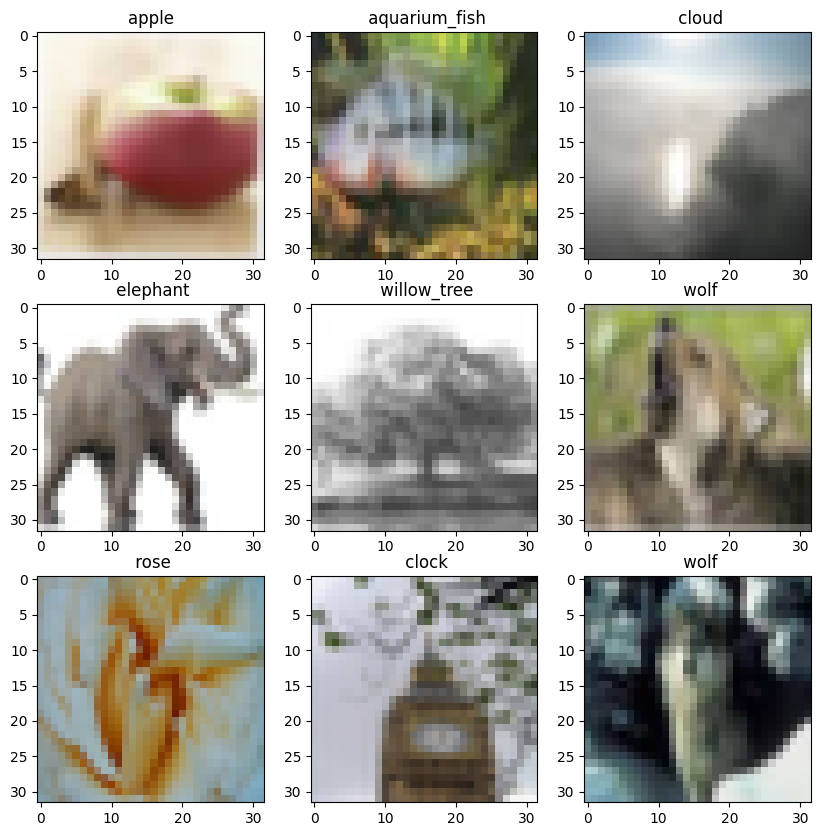

In [51]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(10, 10))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i])) #express the grid dimensions and the subplot's position in a three-digit number
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

## Ερώτημα 1
---
### Βήμα 1: Σχεδίαση και εκπαίδευση των μοντέλων

 Σχεδίαστε και εκπαιδεύστε τα μοντέλα  **LeNet, AlexNet και  VGG**, καθώς και ένα δικό σας μοντέλο (ονομάστε το π.χ. **MyCNN**) χρησιμοποιώντας τον ίδιο αλγορίθμο βελτιστοποίησης ([optimizer](https://keras.io/api/optimizers/)), την ίδια συνάρτηση κόστους [loss function](https://keras.io/api/losses/), το ίδιο μέγεθος παρτίδας (batch size) και 50 εποχές (epochs) `*`.

 Για την εκτίμηση της απόδοσης των μοντέλων να χρησιμοποιήσετε ως μετρική ([metrics](https://keras.io/api/metrics/)) την F1-score.


`*`
 Μπορείτε να πειραματιστείτε με τον optimizer, την loss function και το batch size για τα 4 μοντέλα πριν καταλήξετε στην τελική σας κοινή, για όλα τα μοντέλα επιλογή.


---
  
### Βήμα 2: Αξιολόγηση των μοντέλων

α. Για κάθε ένα από τα μοντέλα που εκπαιδεύσατε στο Βήμα 1, απεικονίστε σε κοινό διάγραμμα τα F1-scores εκπαίδευσης και επικύρωσης στο σύνολο των εποχών.

β. Αξιολογήστε, αναλυτικά, τα αποτελέσματά σας ως προς τα εξής:
 - Επίδραση του πλήθους των δεδομένων/κλάσεων.
 - Επίδραση του αλγόριθμου βελτιστοποίησης (optimizer)
 - Επίδραση του μεγέθους δέσμης (batch size)
---

### Βήμα 3: Αξιολόγηση F1-score
Αξιολογήστε τα F1-scores, χρησιμοποιώντας το σύνολο ελέγχου σας (test set).

---


## Ερώτημα 2
---
### Βήμα 1: Έλεγχος υπερεκπαίδευσης

Για μοντέλο σας  (**MyCNN**) και μόνο, δοκιμάστε διάφορους συνδυασμούς των ακόλουθων τεχνικών για τον έλεγχο της υπερεκπαίδευσης (overfitting), ώστε το μοντέλο σας να γενικεύει καλύτερα, όπως:

- Dropout ([Dropout](https://www.tensorflow.org/tutorials/images/classification#dropout))

- Επαύξηση δεδομένων ([Data augmentation](https://www.tensorflow.org/tutorials/images/classification#data_augmentation), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#class_imagedatagenerator))

---
### Βήμα 2: Αξιολόγηση
Αξιολογήστε τα αποτελέσματά σας, βάσει του F1 score για το σύνολο επικύρωσης και για το σύνολο ελέγχου

---


## Ερώτημα 3
---
### Βήμα 1: Μεταφορά γνώσης
Εφαρμόστε μεταφορά γνώσης (transfer learning) στο δικό σας μοντέλο (**MyCNN**), που αξιολογήσατε ως καλύτερο προς το F1 score στην αντιμετώπιση της υπερεκπαίδεσης.

Για το transfer learning, επιλέξτε το [VGG19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19)  και το [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) για μεταφορά μάθησης.

α. "Παγώστε" τη συνελικτική βάση και εκπαιδεύστε την κεφαλή ταξινόμησης (classification head - σημαία trainable = False).  

β. Εκπαιδέστε μόνο ένα ποσοστό των επιπέδων, το οποίο βρίσκεται προς την έξοδο του δικτύου. Οι σημαίες trainable εδώ θα πρέπει να οριστούν ανά επίπεδο.

---
### Βήμα 2: Αξιολόγηση

Αξιολογήστε τα αποτελέσματά σας, βάσει του F1 score για το σύνολο επικύρωσης και για το σύνολο ελέγχου.

---

## Διαχείριση μνήμης (TFRecord)
Η φόρτωση δεδομένων με τον τρόπο που το κάναμε παραπάνω στο απλό παράδειγμα υλοποίησης είναι πολύ βολική αλλά δεν είναι αποτελεσματική ως προς τη διαχείριση της μνήμης. Συγκεκριμένα, με τον τρόπο αυτό, τα δεδομένα αποθηκεύονται απευθείας σε μεταβλητές, οι οποίες όλες μαζί καταλαμβάνουν τη RAM της CPU ή της GPU, κάτι που κάνει αδύνατη τη διαχείριση μεγάλων datasets ή τον μεταχηματισμό των δεδομένων όπως όταν κάνουμε αύξηση δεδομένων (data augmentation).

Για να παρακαμφθεί αυτό το πρόβλημα, υπάρχει η δυνατότητα της σειριοποίησης των δεδομένων (serialization) και της αποθήκευσής τους σε αρχεία μεσαίου μεγέθους (κάποιων MB) τα οποία μπορούν να αναγνωστούν γραμμικά.

Το φορμάτ TFRecord είναι ένα φορμάτ που επιτρέπει την αποθήκευση σειράς δυαδικών εγγραφών. Διαβάστε σχετικά για το [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) και [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data).

Σημειώστε ότι με τη μέθοδο αυτή θα πρέπει να γίνει import η `tensorflow_datasets` και να χρησιμοποιήσουμε την `tfds.load` ώστε να αποθηκευθεί το σύνολο δεδομένων σε αρχεία tfrecord στο δίσκο (δείτε [εδώ](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) ένα παράδειγμα). Φυσικά μπορούμε να μετατρέψουμε και τα πρωτογενή δεδομένα (raw data) του dataset όπως αρχεία jpg σε φορματ tfrecord όπως [εδώ](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d).


In [52]:
# Function to create a mapping dictionary from unique labels to a new index starting from 0
def create_label_mapping(labels):
    unique_labels = np.unique(labels)
    return {label: index for index, label in enumerate(unique_labels)}

# Function to apply the mapping to the dataset
def apply_mapping(labels, mapping_dict):
    return np.vectorize(mapping_dict.get)(labels)

# Create the mapping dictionary from the existing labels in y_train
label_mapping = create_label_mapping(y_train)

# Apply the mapping to training, testing, and validation sets
y_train_mapped = apply_mapping(y_train, label_mapping)
y_test_mapped = apply_mapping(y_test, label_mapping)
y_val_mapped = apply_mapping(y_val, label_mapping)

# Reshape labels to match the expected format for model training
y_train = y_train_mapped.reshape(-1, 1)
y_test = y_test_mapped.reshape(-1, 1)
y_val = y_val_mapped.reshape(-1, 1)

# Check the changes
print("Mapped train labels shape:", y_train.shape)
print("Mapped test labels shape:", y_test.shape)
print("Mapped validation labels shape:", y_val.shape)


Mapped train labels shape: (8500, 1)
Mapped test labels shape: (2000, 1)
Mapped validation labels shape: (1500, 1)


In [54]:
import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score

In [55]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/Lab2_E&B')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
num_classes = 20

#**ΕΡΩΤΗΜΑ 1**

In [16]:
'''#doesnt work
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.num_classes = 20  # Fixed number of classes
        self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(self.num_classes,))
        self.false_positives = self.add_weight(name='fp', initializer='zeros', shape=(self.num_classes,))
        self.false_negatives = self.add_weight(name='fn', initializer='zeros', shape=(self.num_classes,))

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(y_true, tf.int32)
        sample_weight = tf.cast(sample_weight, self.dtype) if sample_weight is not None else None

        # Calculate updates for all classes simultaneously
        tp = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=self.dtype, weights=sample_weight)
        total_pred = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=self.dtype)
        total_true = tf.math.confusion_matrix(y_true, y_true, num_classes=self.num_classes, dtype=self.dtype)

        self.true_positives.assign_add(tf.linalg.diag_part(tp))
        self.false_positives.assign_add(tf.reduce_sum(total_pred, axis=0) - tf.linalg.diag_part(tp))
        self.false_negatives.assign_add(tf.reduce_sum(total_true, axis=0) - tf.linalg.diag_part(tp))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_states(self):
        self.true_positives.assign(tf.zeros(self.num_classes))
        self.false_positives.assign(tf.zeros(self.num_classes))
        self.false_negatives.assign(tf.zeros(self.num_classes))
'''

"#doesnt work\nclass F1Score(tf.keras.metrics.Metric):\n    def __init__(self, name='f1_score', **kwargs):\n        super(F1Score, self).__init__(name=name, **kwargs)\n        self.num_classes = 20  # Fixed number of classes\n        self.true_positives = self.add_weight(name='tp', initializer='zeros', shape=(self.num_classes,))\n        self.false_positives = self.add_weight(name='fp', initializer='zeros', shape=(self.num_classes,))\n        self.false_negatives = self.add_weight(name='fn', initializer='zeros', shape=(self.num_classes,))\n\n    def update_state(self, y_true, y_pred, sample_weight=None):\n        y_pred = tf.argmax(y_pred, axis=1)\n        y_true = tf.cast(y_true, tf.int32)\n        sample_weight = tf.cast(sample_weight, self.dtype) if sample_weight is not None else None\n\n        # Calculate updates for all classes simultaneously\n        tp = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=self.dtype, weights=sample_weight)\n        tota

## **LeNet**

In [125]:
LeNet = models.Sequential([
    # C1: Convolutional layer, 6 filters (kernels) of size 5x5 with stride 1
    layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='sigmoid', input_shape=(32, 32, 3), padding="same"),
    # S2: Subsampling/Pooling layer, pooling size 2x2 and stride 2
    layers.AveragePooling2D(pool_size=(2, 2), strides=2),

    # C3: Second convolutional layer, 16 filters of size 5x5 with stride 1
    layers.Conv2D(16, kernel_size=(5, 5), activation='sigmoid', padding="valid"),
    # S4: Subsampling/Pooling layer, pooling size 2x2 and stride 2x2
    layers.AveragePooling2D(pool_size=(2, 2), strides=2),

    # Flatten the CNN output to feed it with fully connected layers
    layers.Flatten(),

    # C5: Fully connected layer with 120 neurons
    layers.Dense(120, activation='sigmoid'),

    # F6: Fully connected layer with 84 neurons
    layers.Dense(84, activation='sigmoid'),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

LeNet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), #Sparse Categorical Crossentropy is used when your target labels are integers
              metrics=['accuracy'])

# Display the model's architecture
LeNet.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d (Average  (None, 16, 16, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_39 (Flatten)        (None, 576)               0         
                                                                 
 dense_115 (Dense)           (None, 120)             

In [126]:
history = LeNet.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val))
path = '/content/drive/My Drive/Lab2_E&B/LeNet.h5'
LeNet.save(path)

Epoch 1/50
67/67 [==============================] - 12s 163ms/step - loss: 3.0101 - accuracy: 0.0514 - val_loss: 3.0014 - val_accuracy: 0.0407
Epoch 2/50
67/67 [==============================] - 15s 226ms/step - loss: 2.9207 - accuracy: 0.1047 - val_loss: 2.7358 - val_accuracy: 0.1647
Epoch 3/50
67/67 [==============================] - 12s 173ms/step - loss: 2.5880 - accuracy: 0.1984 - val_loss: 2.4886 - val_accuracy: 0.2380
Epoch 4/50
67/67 [==============================] - 7s 110ms/step - loss: 2.4005 - accuracy: 0.2407 - val_loss: 2.3594 - val_accuracy: 0.2673
Epoch 5/50
67/67 [==============================] - 10s 154ms/step - loss: 2.2977 - accuracy: 0.2664 - val_loss: 2.2907 - val_accuracy: 0.2860
Epoch 6/50
67/67 [==============================] - 8s 119ms/step - loss: 2.2353 - accuracy: 0.2801 - val_loss: 2.2385 - val_accuracy: 0.3000
Epoch 7/50
67/67 [==============================] - 10s 145ms/step - loss: 2.1931 - accuracy: 0.2942 - val_loss: 2.1919 - val_accuracy: 0.3080
E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


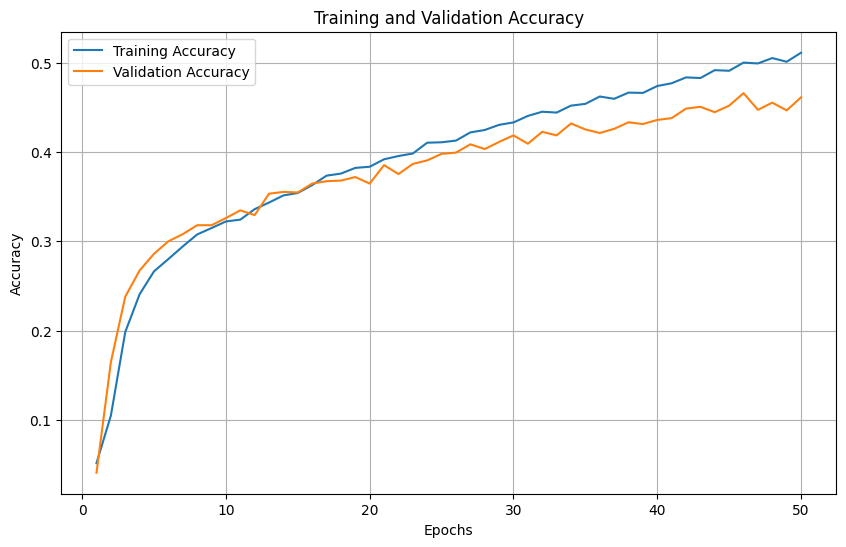

In [127]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [129]:
test_loss, test_accuracy = LeNet.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 1s - loss: 1.7323 - accuracy: 0.4355 - 1s/epoch - 19ms/step
Test Loss: 1.7323036193847656
Test Accuracy: 0.43549999594688416


In [128]:
# Predict the labels
y_pred = LeNet.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 1s 13ms/step
F1 Score: 0.4280155350023137


##**AlexNet**

In [ ]:
AlexNet = keras.Sequential([
    layers.UpSampling2D(size=(7,7), interpolation='bilinear', input_shape=(32, 32, 3)),  # 32*7 = 224
    layers.Conv2D(96, kernel_size=11, strides=4, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Conv2D(256, kernel_size=5, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Conv2D(384, kernel_size=3, padding='same'),
    layers.ReLU(),
    layers.Conv2D(384, kernel_size=3, padding='same'),
    layers.ReLU(),
    layers.Conv2D(256, kernel_size=3, padding='same'),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=3, strides=2),
    layers.Flatten(),
    layers.Dense(4096),
    layers.ReLU(),
    layers.Dropout(0.5),
    layers.Dense(4096),
    layers.ReLU(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

AlexNet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

AlexNet.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_1 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 re_lu_7 (ReLU)              (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 re_lu_8 (ReLU)              (None, 27, 27, 256)     

In [ ]:
history = AlexNet.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
path = '/content/drive/My Drive/Lab2_E&B/AlexNet.h5'
AlexNet.save(path)

Epoch 1/10
67/67 [==============================] - 1449s 21s/step - loss: 3.0017 - accuracy: 0.0512 - val_loss: 2.9959 - val_accuracy: 0.0427
Epoch 2/10
67/67 [==============================] - 1356s 20s/step - loss: 2.9843 - accuracy: 0.0647 - val_loss: 2.9469 - val_accuracy: 0.0900
Epoch 3/10
67/67 [==============================] - 1322s 20s/step - loss: 2.6831 - accuracy: 0.1394 - val_loss: 2.4622 - val_accuracy: 0.1767
Epoch 4/10
67/67 [==============================] - 1342s 20s/step - loss: 2.3460 - accuracy: 0.2156 - val_loss: 2.2334 - val_accuracy: 0.2600
Epoch 5/10
67/67 [==============================] - 1333s 20s/step - loss: 2.2012 - accuracy: 0.2698 - val_loss: 2.0936 - val_accuracy: 0.3107
Epoch 6/10
67/67 [==============================] - 1332s 20s/step - loss: 2.0335 - accuracy: 0.3311 - val_loss: 2.0051 - val_accuracy: 0.3387
Epoch 7/10
67/67 [==============================] - 1317s 20s/step - loss: 1.8937 - accuracy: 0.3847 - val_loss: 1.8278 - val_accuracy: 0.4027

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


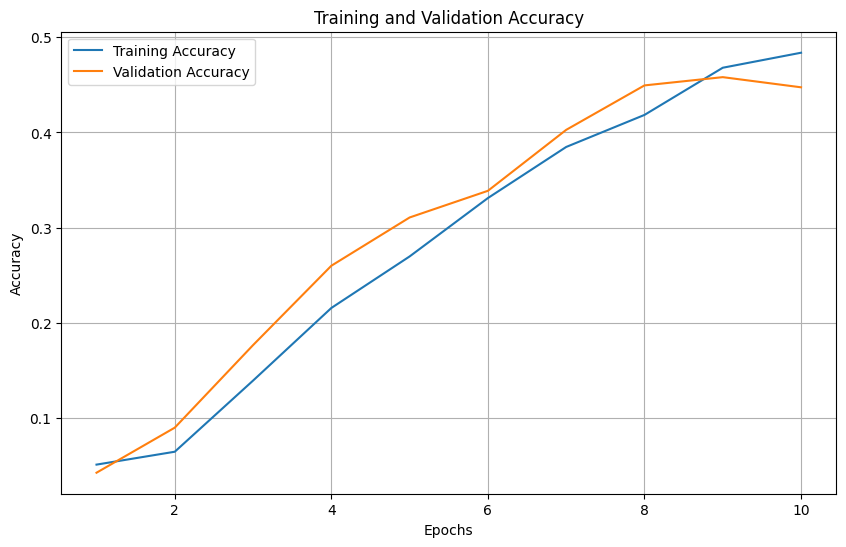

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = AlexNet.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 103s - loss: 1.6999 - accuracy: 0.4585 - 103s/epoch - 2s/step
Test Loss: 1.6998788118362427
Test Accuracy: 0.4584999978542328


In [ ]:
# Predict the labels
y_pred = AlexNet.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 79s 1s/step
F1 Score: 0.4522805603369163


##**VGG**

In [ ]:
VGG = keras.Sequential([
        layers.UpSampling2D(size=(7,7), interpolation='bilinear', input_shape=(32, 32, 3)),  # 32*7 = 224

        # Conv Block 1
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2), strides=2),

        # Conv Block 2
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Conv Block 3
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Conv Block 4
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Conv Block 5
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Flattening the layers
        layers.Flatten(),

        # Fully Connected Layers
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

VGG.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

VGG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                        

In [ ]:
history = VGG.fit(x_train, y_train, epochs=2, batch_size=128, validation_data=(x_val, y_val))
path = '/content/drive/My Drive/Lab2_E&B/VGG.h5'
VGG.save(path)

Epoch 1/2
67/67 [==============================] - 9937s 148s/step - loss: 3.1167 - accuracy: 0.0454 - val_loss: 2.9977 - val_accuracy: 0.0433
Epoch 2/2
67/67 [==============================] - 9870s 147s/step - loss: 2.9943 - accuracy: 0.0520 - val_loss: 2.9977 - val_accuracy: 0.0413


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


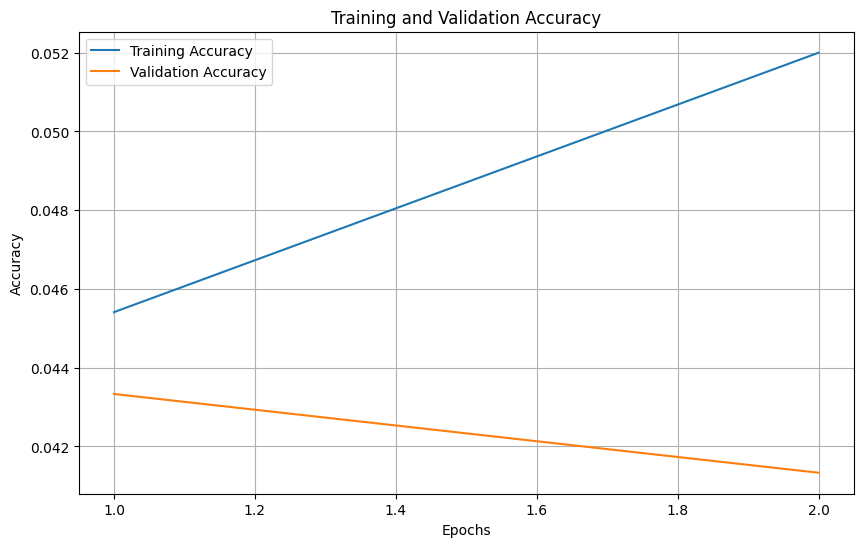

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = VGG.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 697s - loss: 2.9960 - accuracy: 0.0500 - 697s/epoch - 11s/step
Test Loss: 2.9959957599639893
Test Accuracy: 0.05000000074505806


In [ ]:
# Predict the labels
y_pred = VGG.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 656s 10s/step
F1 Score: 0.0047619047619047615


#**MyCNN**

In [ ]:
MyCNN = keras.Sequential([
        layers.InputLayer(input_shape=(32, 32, 3)),

        # Convolutional Layer 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Convolutional Layer 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Convolutional Layer 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Flattening the output of the convolutional layers to feed it into the dense layer
        layers.Flatten(),

        # Dense Layer
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

MyCNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

MyCNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)        

In [ ]:
history = MyCNN.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val))
path = '/content/drive/My Drive/Lab2_E&B/MyCNN.h5'
MyCNN.save(path)

Epoch 1/50
67/67 [==============================] - 52s 761ms/step - loss: 2.4559 - accuracy: 0.2035 - val_loss: 2.2200 - val_accuracy: 0.3280
Epoch 2/50
67/67 [==============================] - 36s 529ms/step - loss: 1.9493 - accuracy: 0.3662 - val_loss: 1.8613 - val_accuracy: 0.4020
Epoch 3/50
67/67 [==============================] - 36s 534ms/step - loss: 1.6998 - accuracy: 0.4465 - val_loss: 1.7234 - val_accuracy: 0.4647
Epoch 4/50
67/67 [==============================] - 35s 517ms/step - loss: 1.5239 - accuracy: 0.4991 - val_loss: 1.6801 - val_accuracy: 0.4833
Epoch 5/50
67/67 [==============================] - 35s 527ms/step - loss: 1.3959 - accuracy: 0.5419 - val_loss: 1.5575 - val_accuracy: 0.5000
Epoch 6/50
67/67 [==============================] - 38s 574ms/step - loss: 1.2571 - accuracy: 0.5824 - val_loss: 1.5844 - val_accuracy: 0.4987
Epoch 7/50
67/67 [==============================] - 36s 535ms/step - loss: 1.1384 - accuracy: 0.6228 - val_loss: 1.4770 - val_accuracy: 0.5367

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


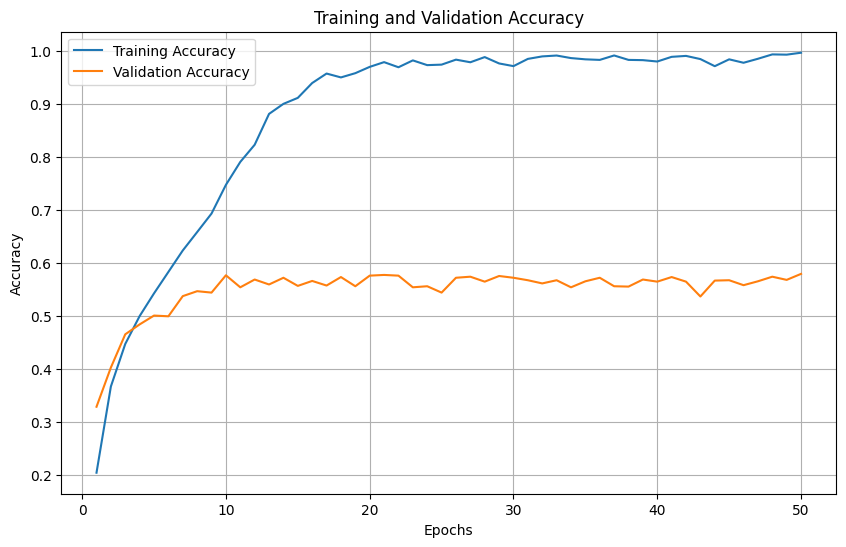

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = MyCNN.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 2s - loss: 3.7379 - accuracy: 0.5840 - 2s/epoch - 31ms/step
Test Loss: 3.737884521484375
Test Accuracy: 0.5839999914169312


In [ ]:
# Predict the labels
y_pred = MyCNN.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 4s 60ms/step
F1 Score: 0.5836560805711613


Υλοποιώ τα μοντέλα με τις δεδομένες προδιαγραφές, χρησιμοποιώντας το API keras του tensorflow. Για το δικό μου μοντέλο, επέλεξα ένα νευρωνικό 11 επιπέδων με ReLU συνάρτηση ενεργοποίησης και 3x3 πυρήνες. Όπως είναι φυσικό, με την εκπαίδευση βελτιώνεται η ακρίβεια του μοντέλου. To καλύτερο f1 score στο test set παρουσιάζεται για το MyCNN: 0.58 (τα αποτελέσματα μπορεί να ήταν διαφορετικά αν είχα εκπαιδεύσει όλα τα μοντέλα για το ίδιο πλήθος εποχών).



---



##Αξιολόγηση Αποτελεσμάτων
**1. Επίδραση του πλήθους των δεδομένων/κλάσεων στην απόδοση του μοντέλου**

Αν αυξήσουμε το πλήθος των δεδομένων, θα βελτιωθεί η απόδοση του μοτέλου, μέχρι να φτάσει σε κορεσμό λόγω overfitting, καθώς θα εκπαιδευτεί καλύτερα στο σύνολο των κλάσεων. Συγχρόνως θα μεγαλώσει ο χρόνος εκτέλεσης. Η αύξηση του αριθμού των κλάσεων θα εισάγει κάποια αβεβαιότητα, οπότε λογικά θα μειώσει την απόδοση.


**2. Επίδραση του αλγόριθμου βελτιστοποίησης (optimizer)**

Με βάσει διάφορα πειράματα, καταλήγω στον Adam Optimizer ως καλύτερη επιλογή, καθώς προσφέρει γρηγορότερη σύγκλιση σε σχέση με τον SGD Optimizer.

**3. Επίδραση του μεγέθους δέσμης (batch size)**

H αύξηση του batch size έχει μεγαλύτερες απαιτήσεις σε πόρους (RAM) και επιταχύνει την εκπαίδευση των μοντέλων αλλά μειώνει την απόδοση. Αυτό συμβαίνει διότι το μοντέλο δεν μαθαίνει τα λεπτομερή χαρακτηριστικά των εικόνων, αγνοώντας τα ως θόρυβο.Ένα μικρό Batch size απ'την άλλη, θα μπορούσε να προκαλέσει overfitting.



#**ΕΡΩΤΗΜΑ 2**

##Dropout - p=0.5

In [ ]:
MyCNN_dr = keras.Sequential([
        layers.InputLayer(input_shape=(32, 32, 3)),

        # Convolutional Layer 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Convolutional Layer 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Convolutional Layer 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),  # Additional Conv layer
        layers.MaxPooling2D((2, 2), strides=2),

        # Flattening the output of the convolutional layers to feed it into the dense layer
        layers.Flatten(),

        # Dense Layer
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

MyCNN_dr.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

MyCNN_dr.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 128)        

In [ ]:
history = MyCNN_dr.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val))
path = '/content/drive/My Drive/Lab2_E&B/MyCNN_dr.h5'
MyCNN_dr.save(path)

Epoch 1/50
67/67 [==============================] - 44s 631ms/step - loss: 2.7201 - accuracy: 0.1182 - val_loss: 2.4654 - val_accuracy: 0.1847
Epoch 2/50
67/67 [==============================] - 61s 904ms/step - loss: 2.3684 - accuracy: 0.2008 - val_loss: 2.1347 - val_accuracy: 0.2560
Epoch 3/50
67/67 [==============================] - 42s 629ms/step - loss: 2.1211 - accuracy: 0.2944 - val_loss: 1.8729 - val_accuracy: 0.3920
Epoch 4/50
67/67 [==============================] - 45s 671ms/step - loss: 1.9300 - accuracy: 0.3647 - val_loss: 1.7649 - val_accuracy: 0.4433
Epoch 5/50
67/67 [==============================] - 43s 647ms/step - loss: 1.7884 - accuracy: 0.4141 - val_loss: 1.6282 - val_accuracy: 0.4880
Epoch 6/50
67/67 [==============================] - 36s 536ms/step - loss: 1.6627 - accuracy: 0.4549 - val_loss: 1.6215 - val_accuracy: 0.4767
Epoch 7/50
67/67 [==============================] - 36s 539ms/step - loss: 1.5580 - accuracy: 0.4914 - val_loss: 1.5013 - val_accuracy: 0.5113

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


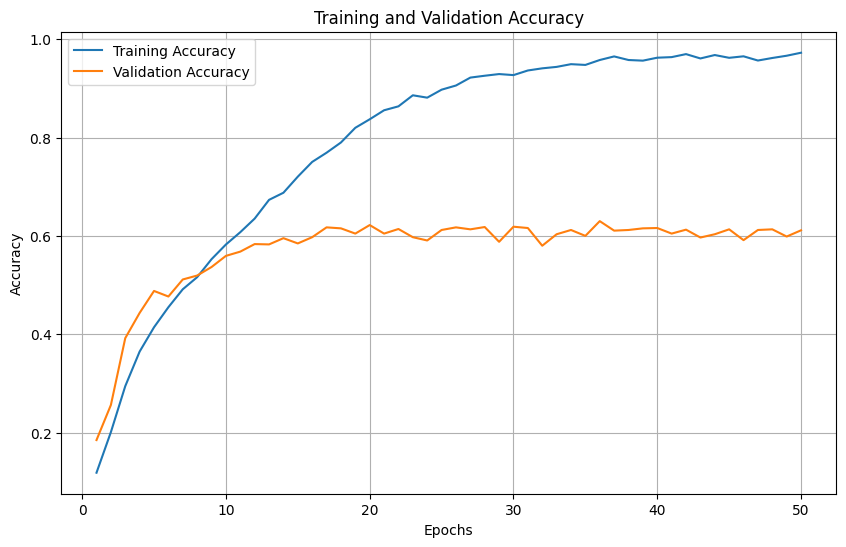

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = MyCNN_dr.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 2s - loss: 2.5261 - accuracy: 0.6135 - 2s/epoch - 32ms/step
Test Loss: 2.526052474975586
Test Accuracy: 0.6134999990463257


In [ ]:
# Predict the labels
y_pred = MyCNN_dr.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 2s 33ms/step
F1 Score: 0.6123854763211962


##Data Augmentation

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly horizontal shift images
    height_shift_range=0.2,  # Randomly vertical shift images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
)

# Prepare the data generator for training
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)

In [ ]:
history = MyCNN.fit(train_generator, batch_size = 128, epochs=50, validation_data=(x_val, y_val))
path = '/content/drive/My Drive/Lab2_E&B/MyCNN_au.h5'
MyCNN.save(path)

Epoch 1/50
67/67 [==============================] - 48s 689ms/step - loss: 1.7326 - accuracy: 0.4894 - val_loss: 1.3994 - val_accuracy: 0.5513
Epoch 2/50
67/67 [==============================] - 43s 645ms/step - loss: 1.3691 - accuracy: 0.5595 - val_loss: 1.3646 - val_accuracy: 0.5760
Epoch 3/50
67/67 [==============================] - 39s 583ms/step - loss: 1.2657 - accuracy: 0.5882 - val_loss: 1.3021 - val_accuracy: 0.5813
Epoch 4/50
67/67 [==============================] - 41s 606ms/step - loss: 1.2523 - accuracy: 0.5980 - val_loss: 1.3154 - val_accuracy: 0.5847
Epoch 5/50
67/67 [==============================] - 44s 659ms/step - loss: 1.2036 - accuracy: 0.6035 - val_loss: 1.2502 - val_accuracy: 0.6067
Epoch 6/50
67/67 [==============================] - 39s 585ms/step - loss: 1.1124 - accuracy: 0.6349 - val_loss: 1.2887 - val_accuracy: 0.6087
Epoch 7/50
67/67 [==============================] - 41s 602ms/step - loss: 1.1053 - accuracy: 0.6360 - val_loss: 1.2629 - val_accuracy: 0.6120

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


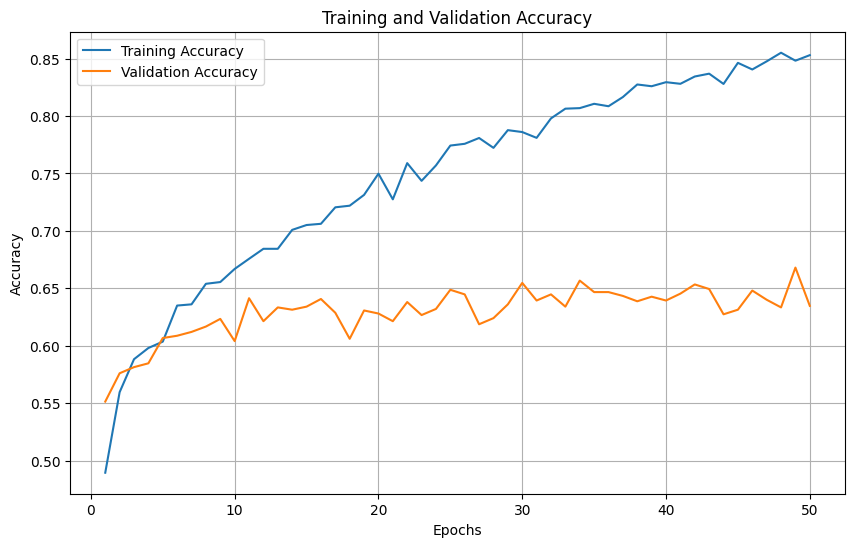

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = MyCNN.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 2s - loss: 1.5479 - accuracy: 0.6250 - 2s/epoch - 32ms/step
Test Loss: 1.5479108095169067
Test Accuracy: 0.625


In [ ]:
# Predict the labels
y_pred = MyCNN.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 2s 33ms/step
F1 Score: 0.6257830120586292


Δοκιμάζω dropout με p=0.5 στα τελικά fully connected/ dense layers και το f1 score βελτιώνεται, αλλά μόνο λίγο. Το Data Augmentation δίνει λίγο καλύτερη ααπόδοση την απόδοση. Οι τεχνικές αυτές βοηθούν να αντιμετωπιστεί το overfitting του μοντέλου, από το οποίο ξεκάθαρα πάσχει.

#**ΕΡΩΤΗΜΑ 3**




In [61]:
#these pretrained models need data normalised with pixel values to a range of [-1, 1]
x_train = (x_train_ds[:-val_size] / 127.5) - 1
x_val = (x_train_ds[-val_size:] / 127.5) - 1
x_test = (x_test_ds / 127.5) - 1

In [62]:
#these pretrained models need labels in one hot format
from keras.utils import to_categorical

y_train_categ = to_categorical(y_train, num_classes)
y_test_categ = to_categorical(y_test, num_classes)
y_val_categ = to_categorical(y_val, num_classes)

data_gen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly horizontal shift images
    height_shift_range=0.2,  # Randomly vertical shift images
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
)

##Train only the head:


###VGG19

In [63]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Resizing
from tensorflow.keras.optimizers import Adam

base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False

# Create a custom top classifier
transf_vgg19 = models.Sequential([
    #Input(shape=(32, 32, 3)),  # Define the input shape explicitly
    #Resizing(224, 224),
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

transf_vgg19.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(), #Categorical Crossentropy is used when your labels are one-hot encoded
              metrics=['accuracy'])

transf_vgg19.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                       

In [64]:
history = transf_vgg19.fit(data_gen.flow(x_train, y_train_categ, batch_size=64), epochs=10, validation_data=(x_val, y_val_categ))
path = '/content/drive/My Drive/Lab2_E&B/transf_vgg19.h5'
transf_vgg19.save(path)

Epoch 1/10
133/133 [==============================] - 154s 1s/step - loss: 2.2764 - accuracy: 0.2811 - val_loss: 1.6410 - val_accuracy: 0.4820
Epoch 2/10
133/133 [==============================] - 195s 1s/step - loss: 1.8514 - accuracy: 0.3992 - val_loss: 1.5295 - val_accuracy: 0.5207
Epoch 3/10
133/133 [==============================] - 195s 1s/step - loss: 1.7413 - accuracy: 0.4301 - val_loss: 1.4377 - val_accuracy: 0.5440
Epoch 4/10
133/133 [==============================] - 144s 1s/step - loss: 1.6615 - accuracy: 0.4601 - val_loss: 1.4109 - val_accuracy: 0.5467
Epoch 5/10
133/133 [==============================] - 145s 1s/step - loss: 1.6279 - accuracy: 0.4747 - val_loss: 1.3673 - val_accuracy: 0.5660
Epoch 6/10
133/133 [==============================] - 168s 1s/step - loss: 1.5993 - accuracy: 0.4814 - val_loss: 1.3971 - val_accuracy: 0.5620
Epoch 7/10
133/133 [==============================] - 145s 1s/step - loss: 1.5663 - accuracy: 0.4941 - val_loss: 1.3527 - val_accuracy: 0.5807

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


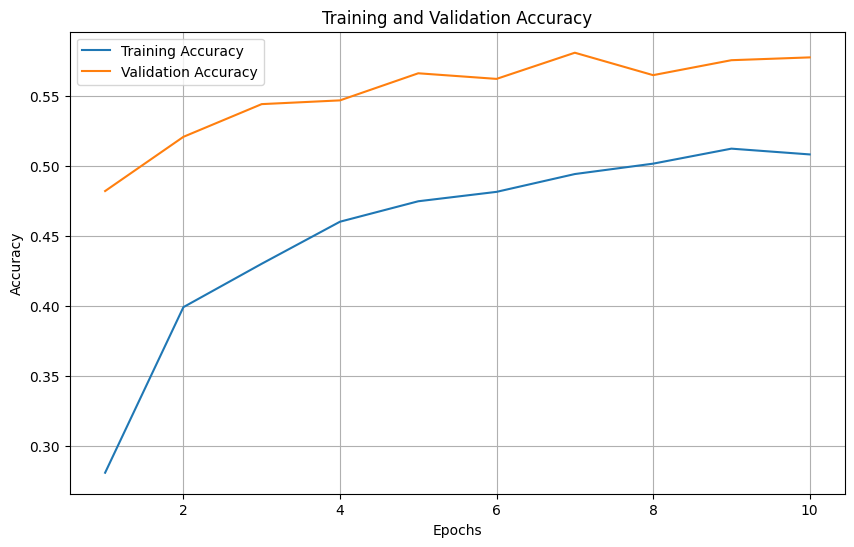

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
test_loss, test_accuracy = transf_vgg19.evaluate(x_test, y_test_categ, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 29s - loss: 1.3373 - accuracy: 0.5715 - 29s/epoch - 466ms/step
Test Loss: 1.3372645378112793
Test Accuracy: 0.5715000033378601


In [67]:
# Predict the labels
y_pred = transf_vgg19.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 29s 465ms/step
F1 Score: 0.5654878687459823


###EfficientNetB0:

In [97]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

#base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
# Freeze all layers in the base model by default
base_model.trainable = False

# Build the model architecture on top of the base model
transf_enb0 = models.Sequential([
    #layers.Input(shape=(32, 32, 3)),
    #layers.Resizing(224, 224),  # Resizing layer to scale up small images
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
transf_enb0.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(), #Categorical Crossentropy is used when your labels are one-hot encoded
              metrics=['accuracy'])

# Display the model's architecture
transf_enb0.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 flatten_31 (Flatten)        (None, 1280)              0         
                                                                 
 dense_91 (Dense)            (None, 512)               655872    
                                                                 
 dropout_60 (Dropout)        (None, 512)               0         
                                                                 
 dense_92 (Dense)            (None, 512)               262656    
                                                                 
 dropout_61 (Dropout)        (None, 512)               0         
                                                     

In [100]:
history = transf_enb0.fit(data_gen.flow(x_train, y_train_categ, batch_size=64), epochs=10, validation_data=(x_val, y_val_categ))
path = '/content/drive/My Drive/Lab2_E&B/transf_enb0.h5'
transf_enb0.save(path)

Epoch 1/10
133/133 [==============================] - 21s 156ms/step - loss: 2.9957 - accuracy: 0.0507 - val_loss: 2.9993 - val_accuracy: 0.0413
Epoch 2/10
133/133 [==============================] - 25s 187ms/step - loss: 2.9957 - accuracy: 0.0486 - val_loss: 2.9993 - val_accuracy: 0.0413
Epoch 3/10
133/133 [==============================] - 20s 153ms/step - loss: 2.9957 - accuracy: 0.0479 - val_loss: 2.9994 - val_accuracy: 0.0413
Epoch 4/10
133/133 [==============================] - 22s 164ms/step - loss: 2.9956 - accuracy: 0.0466 - val_loss: 2.9994 - val_accuracy: 0.0413
Epoch 5/10
133/133 [==============================] - 26s 194ms/step - loss: 2.9956 - accuracy: 0.0505 - val_loss: 2.9992 - val_accuracy: 0.0413
Epoch 6/10
133/133 [==============================] - 20s 150ms/step - loss: 2.9957 - accuracy: 0.0513 - val_loss: 2.9993 - val_accuracy: 0.0413
Epoch 7/10
133/133 [==============================] - 20s 153ms/step - loss: 2.9957 - accuracy: 0.0471 - val_loss: 2.9994 - val_ac

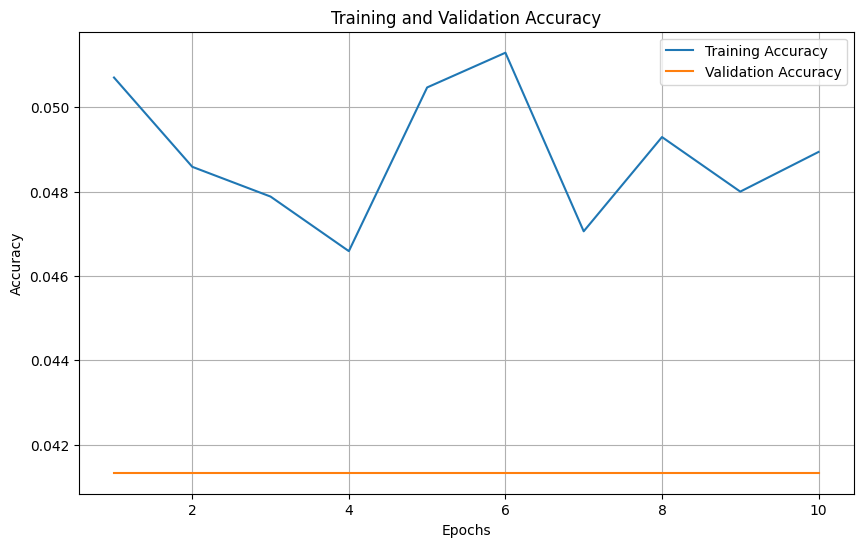

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
test_loss, test_accuracy = transf_enb0.evaluate(x_test, y_test_categ, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 4s - loss: 2.9960 - accuracy: 0.0500 - 4s/epoch - 57ms/step
Test Loss: 2.9960386753082275
Test Accuracy: 0.05000000074505806


In [103]:
# Predict the labels
y_pred = transf_enb0.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 5s 48ms/step
F1 Score: 0.0047619047619047615


##Train final layers + head:

### VGG19:

In [92]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Resizing
from tensorflow.keras.optimizers import Adam

base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for i, layer in enumerate(base_model.layers):
  if i>18:
    layer.trainable = True
  else:
    layer.trainable = False
print(i)

# Create a custom top classifier
transf_vgg19_tr = models.Sequential([
    #Input(shape=(32, 32, 3)),  # Define the input shape explicitly
    #Resizing(224, 224),
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

transf_vgg19_tr.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(), #Categorical Crossentropy is used when your labels are one-hot encoded
              metrics=['accuracy'])

transf_vgg19_tr.summary()

21
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_30 (Flatten)        (None, 512)               0         
                                                                 
 dense_88 (Dense)            (None, 512)               262656    
                                                                 
 dropout_58 (Dropout)        (None, 512)               0         
                                                                 
 dense_89 (Dense)            (None, 512)               262656    
                                                                 
 dropout_59 (Dropout)        (None, 512)               0         
                                                                 
 dense_90 (Dense)            (None, 20)           

In [93]:
history = transf_vgg19_tr.fit(data_gen.flow(x_train, y_train_categ, batch_size=64), epochs=10, validation_data=(x_val, y_val_categ))
path = '/content/drive/My Drive/Lab2_E&B/transf_vgg19_tr.h5'
transf_vgg19_tr.save(path)

Epoch 1/10
133/133 [==============================] - 312s 2s/step - loss: 2.4296 - accuracy: 0.2121 - val_loss: 1.6503 - val_accuracy: 0.4527
Epoch 2/10
133/133 [==============================] - 335s 3s/step - loss: 1.8386 - accuracy: 0.3999 - val_loss: 1.6373 - val_accuracy: 0.4647
Epoch 3/10
133/133 [==============================] - 336s 3s/step - loss: 1.6871 - accuracy: 0.4658 - val_loss: 1.4293 - val_accuracy: 0.5320
Epoch 4/10
133/133 [==============================] - 337s 3s/step - loss: 1.5642 - accuracy: 0.5005 - val_loss: 1.3934 - val_accuracy: 0.5707
Epoch 5/10
133/133 [==============================] - 317s 2s/step - loss: 1.5021 - accuracy: 0.5241 - val_loss: 1.3083 - val_accuracy: 0.5980
Epoch 6/10
133/133 [==============================] - 316s 2s/step - loss: 1.4376 - accuracy: 0.5427 - val_loss: 1.2729 - val_accuracy: 0.6033
Epoch 7/10
133/133 [==============================] - 341s 3s/step - loss: 1.3927 - accuracy: 0.5614 - val_loss: 1.3224 - val_accuracy: 0.5873

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


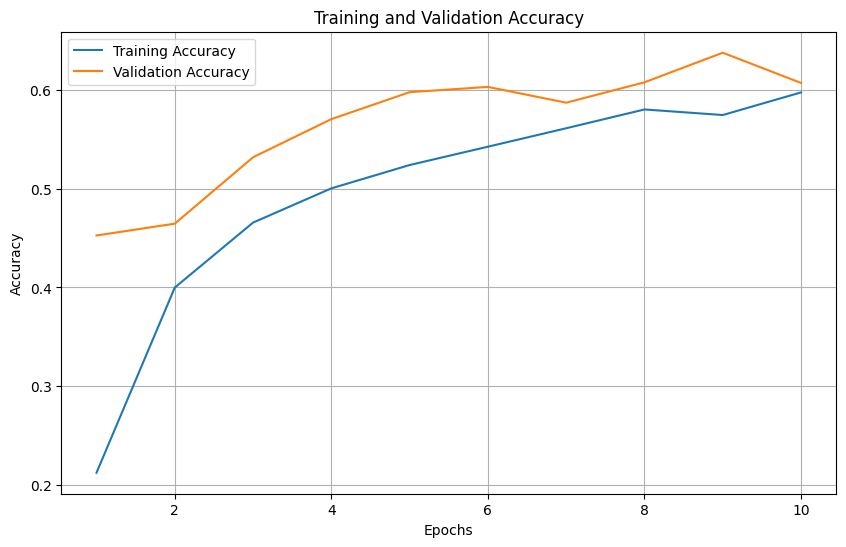

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
test_loss, test_accuracy = transf_vgg19_tr.evaluate(x_test, y_test_categ, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 34s - loss: 1.3060 - accuracy: 0.6115 - 34s/epoch - 548ms/step
Test Loss: 1.3059606552124023
Test Accuracy: 0.6115000247955322


In [96]:
# Predict the labels
y_pred = transf_vgg19_tr.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 38s 583ms/step
F1 Score: 0.601704781080459


###EfficientNetB0:

In [117]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

for i, layer in enumerate(base_model.layers):
  if i>210:
    layer.trainable = True
  else:
    layer.trainable = False
print(i)

transf_enb0_tr = models.Sequential([
    #layers.Input(shape=(32, 32, 3)),
    #layers.Resizing(224, 224),  # Resizing layer to scale up small images
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
transf_enb0_tr.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Display the model's architecture
transf_enb0_tr.summary()

237
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 flatten_38 (Flatten)        (None, 1280)              0         
                                                                 
 dense_112 (Dense)           (None, 512)               655872    
                                                                 
 dropout_74 (Dropout)        (None, 512)               0         
                                                                 
 dense_113 (Dense)           (None, 512)               262656    
                                                                 
 dropout_75 (Dropout)        (None, 512)               0         
                                                 

In [118]:
history = transf_enb0_tr.fit(data_gen.flow(x_train, y_train_categ, batch_size=64), epochs=10, validation_data=(x_val, y_val_categ))
path = '/content/drive/My Drive/Lab2_E&B/transf_enb0_tr.h5'
transf_enb0_tr.save(path)

Epoch 1/10
133/133 [==============================] - 51s 280ms/step - loss: 3.1113 - accuracy: 0.0527 - val_loss: 2.9930 - val_accuracy: 0.0507
Epoch 2/10
133/133 [==============================] - 36s 270ms/step - loss: 3.0216 - accuracy: 0.0586 - val_loss: 2.9902 - val_accuracy: 0.0540
Epoch 3/10
133/133 [==============================] - 35s 262ms/step - loss: 2.9717 - accuracy: 0.0695 - val_loss: 3.0023 - val_accuracy: 0.0533
Epoch 4/10
133/133 [==============================] - 34s 253ms/step - loss: 2.9442 - accuracy: 0.0721 - val_loss: 2.9585 - val_accuracy: 0.0720
Epoch 5/10
133/133 [==============================] - 34s 256ms/step - loss: 2.9187 - accuracy: 0.0776 - val_loss: 2.9894 - val_accuracy: 0.0460
Epoch 6/10
133/133 [==============================] - 35s 267ms/step - loss: 2.9050 - accuracy: 0.0838 - val_loss: 2.8622 - val_accuracy: 0.1287
Epoch 7/10
133/133 [==============================] - 34s 252ms/step - loss: 2.8917 - accuracy: 0.0840 - val_loss: 3.0773 - val_ac

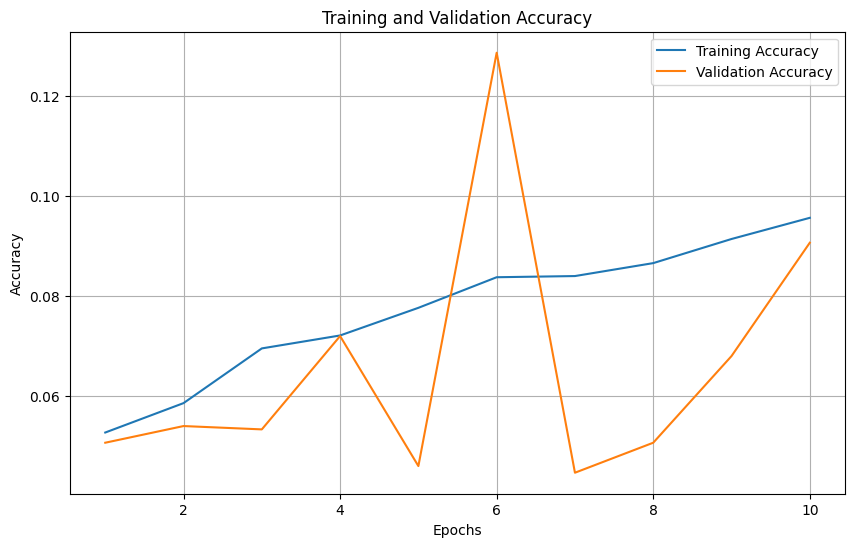

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [123]:
test_loss, test_accuracy = transf_enb0_tr.evaluate(x_test, y_test_categ, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

63/63 - 4s - loss: 2.9119 - accuracy: 0.0870 - 4s/epoch - 65ms/step
Test Loss: 2.9119293689727783
Test Accuracy: 0.08699999749660492


In [124]:
# Predict the labels
y_pred = transf_enb0.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)  #model outputs probabilities per class

# Calculate the F1 Score
f1 = f1_score(y_test, y_pred_labels, average='macro')
print(f"F1 Score: {f1}")

63/63 [==============================] - 3s 49ms/step
F1 Score: 0.0047619047619047615


Στην περίπτωση που μένει σταθερό όλο το προεκπαιδευμένο μοντέλο, το vgg19 δίνει κανονική απόδοση, ενώ το EfficientNetB0 δίνει άθλια. Αυτό το αποδίδω στην διαφορά διαστάσεων δεδομένων εισόδου. Συγεκριμένα και τα δύο μοντέλα είναι εκπαιδευμένα σε εικόνες 224x224x3, ενώ τα δεδομένα που χρησιμοποιώ είναι 32x32x3. Θα μπορούσα να εφαρμόσω μια τεχνική resizing, αλλά αυτό θα προϋπέθετε upsampling σε μεγάλο βαθμό και δεν θα έδινε την αναμενόμενη απόδοση. Επομένως επιλέγω να μην κάνω resize και να τροφοδοτήσω τα δεδομένα μου κατευθείαν. Το vgg19 είναι πιο απλό δίκτυο και προσαρμόζεται στην αλλαγή, αλλά η αυξημένη πολυπλοκότητα του δεύτερου (237 επίπεδα) το καθιστά πιο δυσκίνητο.

Στο δεύτερο ερώτημα επιλέγω να εκπαιδεύσω και ένα ποσοστό των τελευταίων επιπέδων των προεκπαιδευμένων μοντέλων (fine-tuning). Aυτό φυσικά βελτιώνει την απόδοση σε κάθε περίπτωση.